# House Price Prediction

In [2]:
#Importing Library used for modelling and eda
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import rcParams
rcParams['figure.figsize'] = 20,12

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import SimpleImputer


from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

path = 'C:/Users/shubh/Desktop/Python And Finance/house-prices-advanced-regression-techniques' 

In [3]:
train = pd.read_csv(f"{path}/train.csv")
test =  pd.read_csv(f"{path}/test.csv")

## Exploratory Visualization

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

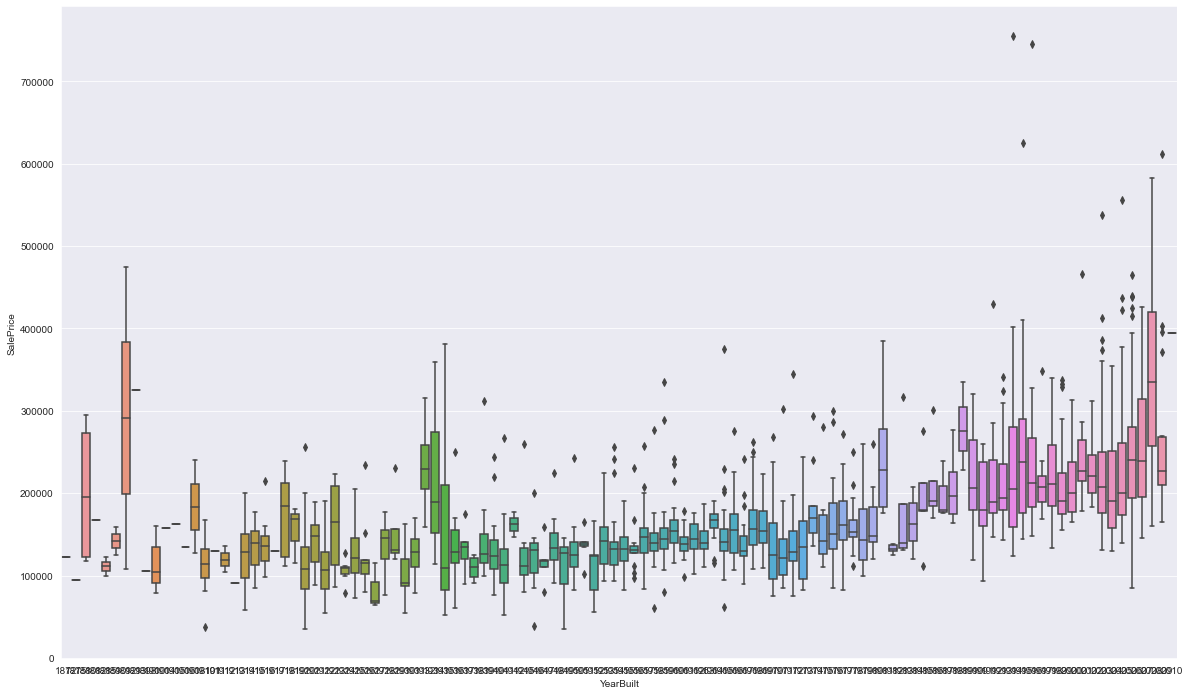

In [4]:
sns.boxplot(train.YearBuilt, train.SalePrice)

We can notice that the houses built later on are more expensive. Might be useful when encoding time features

(0.0, 800000.0)

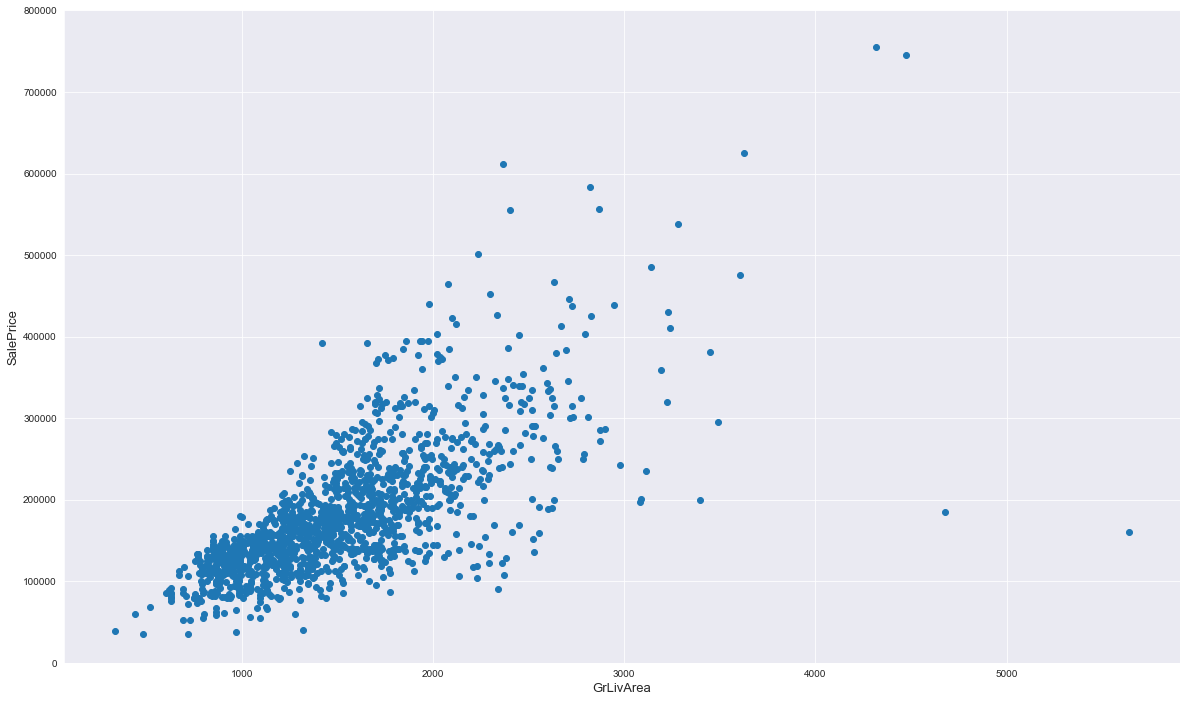

In [5]:
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

We can see there are outliers in our dataset. Lets omit these outliers from our dataset.

In [6]:
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)

In [7]:
full=pd.concat([train,test], ignore_index=True)
full 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2913,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2914,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2915,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [8]:
full.drop(['Id'],axis=1, inplace=True)  #drop id from our dataset
full.shape

(2917, 80)

## Data Cleaning and Prepocessing

In [9]:
aa = full.isnull().sum()
aa[aa>0].sort_values(ascending=False)   #sort missing columns

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
GarageCars         1
GarageArea         1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
Electrical         1
dtype: int64

Let's first imput the missing values of LotFrontage based on the median of LotArea and Neighborhood. Since LotArea is a continuous feature, We use qcut to divide it into 10 parts.

In [10]:
full.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.789474   51.0    95
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        65.153409   64.5   176
Gilbert        74.207207   64.0   111
IDOTRR         62.241379   60.0    87
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.210667   73.0   375
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.551020   72.0    98
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

In [11]:
full["LotAreaCut"] = pd.qcut(full.LotArea,10)

In [12]:
full.groupby(['LotAreaCut'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4921.8]    35.741036   34.0   251
(4921.8, 7007.2]      55.460674   52.0   267
(7007.2, 7949.0]      62.959839   62.0   249
(7949.0, 8740.4]      67.113725   65.0   255
(8740.4, 9452.0]      69.959184   70.0   245
(9452.0, 10148.8]     73.988235   75.0   255
(10148.8, 11000.0]    73.636364   75.0   253
(11000.0, 12196.8]    83.371681   82.0   226
(12196.8, 14285.8]    84.973684   85.0   228
(14285.8, 215245.0]   92.846535   90.0   202

In [13]:
full['LotFrontage']=full.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [14]:
# Since some combinations of LotArea and Neighborhood are not available, so we just LotAreaCut alone.
full['LotFrontage']=full.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

Then we filling in other missing values according to data_description.

In [16]:
cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    full[col].fillna(0, inplace=True)

In [17]:
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    full[col].fillna("None", inplace=True)

In [18]:
# fill in with mode
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    full[col].fillna(full[col].mode()[0], inplace=True)

In [19]:
full.isnull().sum()[full.isnull().sum()>0]

SalePrice    1459
dtype: int64

Now we only have missing value that needs to be predicted,

## Feature Engineering
Convert some numerical features into categorical features. It's better to use LabelEncoder and get_dummies for these features.

In [20]:
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    full[col]=full[col].astype(str)

In [21]:
full.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])

SalePrice                
                     mean    median count
MSSubClass                               
120         200779.080460  192000.0    87
150                   NaN       NaN     0
160         138647.380952  146000.0    63
180         102300.000000   88500.0    10
190         129613.333333  128250.0    30
20          185224.811567  159250.0   536
30           95829.724638   99900.0    69
40          156125.000000  142500.0     4
45          108591.666667  107500.0    12
50          143302.972222  132000.0   144
60          240403.542088  216000.0   297
70          166772.416667  156000.0    60
75          192437.500000  163500.0    16
80          169736.551724  166500.0    58
85          147810.000000  140750.0    20
90          133541.076923  135980.0    52

So basically I'll do a mapping based on MS cloumns
- '180' : 1
- '30' : 2   '45' : 2
- '190' : 3, '50' : 3, '90' : 3,
- '85' : 4, '40' : 4, '160' : 4
- '70' : 5, '20' : 5, '75' : 5, '80' : 5, '150' : 5
- '120': 6, '60' : 6
Below I also add a small "o" in front of the features so as to keep the original features to use get_dummies

In [22]:
def map_values():
    full["oMSSubClass"] = full.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    full["oMSZoning"] = full.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    full["oNeighborhood"] = full.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    full["oCondition1"] = full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    full["oBldgType"] = full.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    full["oHouseStyle"] = full.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    full["oExterior1st"] = full.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    full["oMasVnrType"] = full.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    full["oExterQual"] = full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFoundation"] = full.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    full["oBsmtQual"] = full.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oBsmtExposure"] = full.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    full["oHeating"] = full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    full["oHeatingQC"] = full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oKitchenQual"] = full.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFunctional"] = full.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    full["oFireplaceQu"] = full.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oGarageType"] = full.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    full["oGarageFinish"] = full.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    full["oPavedDrive"] = full.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    full["oSaleType"] = full.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    full["oSaleCondition"] = full.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                
                        
                        
    
    return "Done!"

In [23]:
map_values()

'Done!'

In [24]:
# drop two unwanted columns
full.drop("LotAreaCut",axis=1,inplace=True)
full.drop(['SalePrice'],axis=1,inplace=True)

### Pipeline
Next we can build a pipeline. It's convenient to experiment different feature combinations once you've got a pipeline.
Label Encoding three "Year" features.

In [25]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        return X

In [26]:
#Apply log1p to the skewed features, then get_dummies. 

class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

In [27]:
# build pipeline
pipe = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [28]:
# save the original data for later use
full2 = full.copy()

In [29]:
data_pipe = pipe.fit_transform(full2)

In [30]:
data_pipe

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,9.042040,7,5,110,53,5.283204,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9.169623,6,8,83,26,0.000000,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
2,68.0,9.328212,7,5,108,52,5.093750,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9.164401,7,5,25,20,0.000000,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
4,84.0,9.565284,8,5,107,50,5.860786,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,21.0,7.568896,4,7,77,20,0.000000,0.0,0.0,546.0,...,0,0,0,1,0,0,0,0,1,0
2913,21.0,7.546974,4,5,77,20,0.000000,252.0,0.0,294.0,...,0,0,0,1,1,0,0,0,0,0
2914,160.0,9.903538,5,7,67,46,0.000000,1224.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,0
2915,62.0,9.253591,5,5,99,42,0.000000,337.0,0.0,575.0,...,0,0,0,1,0,0,0,0,1,0


In [31]:
scaler = RobustScaler() # try to deal with  outliers using robust scalar

In [32]:
n_train=train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

### Feature Selection:

In [33]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

Lasso(alpha=0.001)

In [34]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipe.columns)
FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
GrLivArea,0.108860
OverallQual,0.102520
2ndFlrSF,0.074243
YearBuilt,0.068834
1stFlrSF,0.059812
...,...
BsmtFinType1_Unf,-0.016686
SaleCondition_Abnorml,-0.018823
KitchenAbvGr_2,-0.027021
CentralAir_N,-0.034036


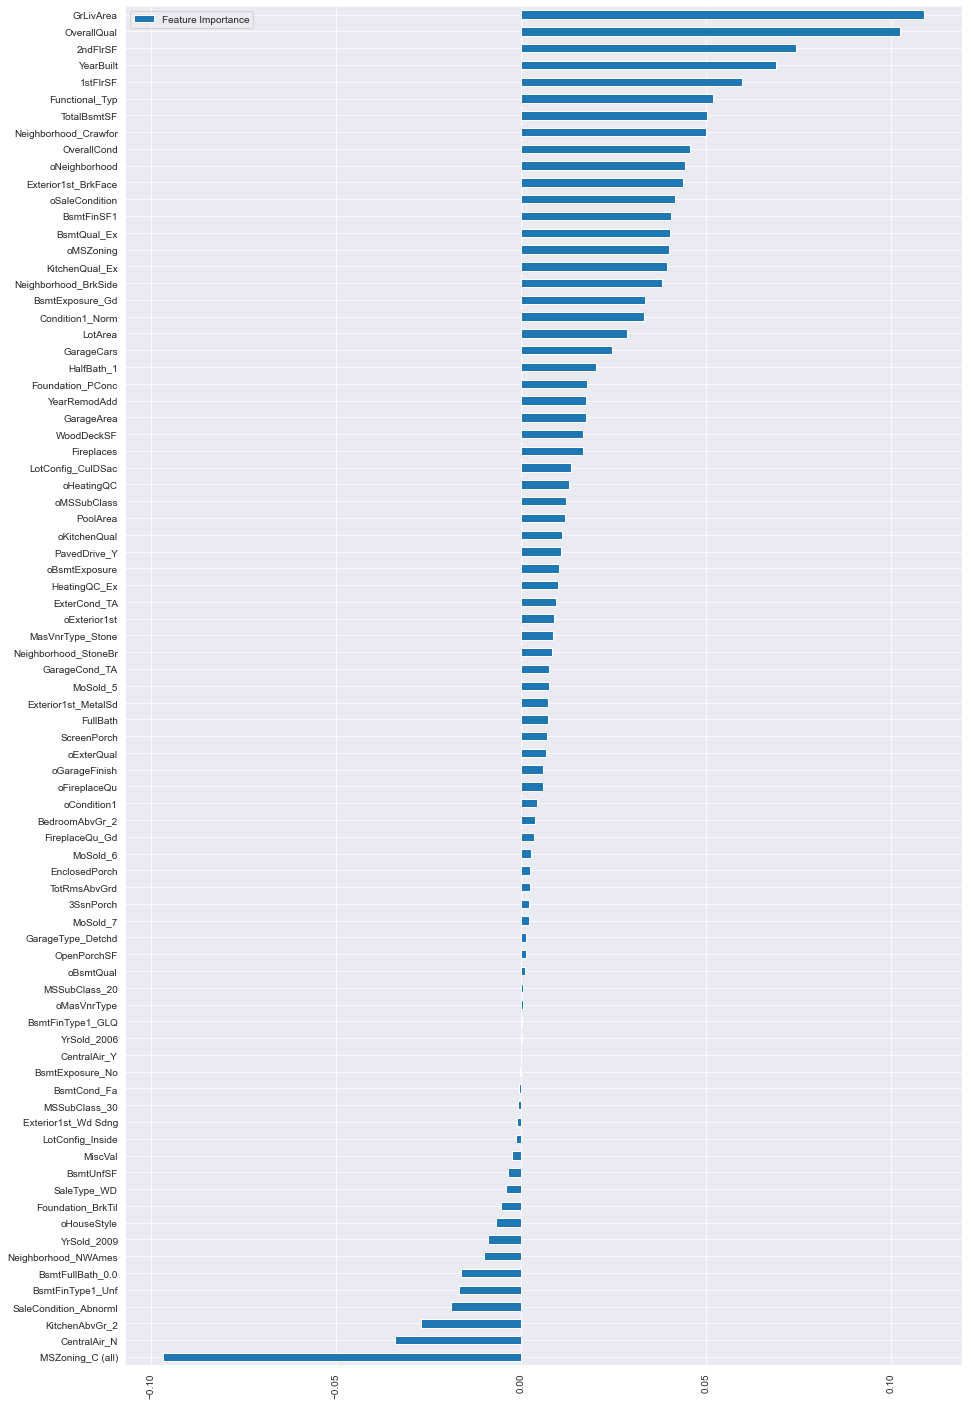

In [35]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

Based on the plot above we should try to merge features to create more informative features.

In [36]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
            return X

In [37]:
pipe = Pipeline([
    ('labenc', labelenc()),
    ('add_feature', add_feature(additional=2)),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [38]:
full_pipe = pipe.fit_transform(full)
full_pipe

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,9.042040,7,5,110,53,5.283204,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9.169623,6,8,83,26,0.000000,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
2,68.0,9.328212,7,5,108,52,5.093750,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9.164401,7,5,25,20,0.000000,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
4,84.0,9.565284,8,5,107,50,5.860786,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,21.0,7.568896,4,7,77,20,0.000000,0.0,0.0,546.0,...,0,0,0,1,0,0,0,0,1,0
2913,21.0,7.546974,4,5,77,20,0.000000,252.0,0.0,294.0,...,0,0,0,1,1,0,0,0,0,0
2914,160.0,9.903538,5,7,67,46,0.000000,1224.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,0
2915,62.0,9.253591,5,5,99,42,0.000000,337.0,0.0,575.0,...,0,0,0,1,0,0,0,0,1,0


In [39]:
n_train=train.shape[0]
X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

In [40]:
pca = PCA(n_components=410)

In [41]:
X_scaled=pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)
X_scaled.shape, test_X_scaled.shape

((1458, 410), (1459, 410))

## Modeling & Evaluation

In [42]:
# define cross validation strategy
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

Models include:

- LinearRegression
- Ridge
- Lasso
- Random Forrest
- Gradient Boosting Tree
- Support Vector Regression
- Linear Support Vector Regression
- ElasticNet
- Stochastic Gradient Descent
- BayesianRidge
- KernelRidge
- ExtraTreesRegressor
- XgBoost


In [43]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [44]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 581466512.715703, 163267785.0771
Ridge: 0.117596, 0.0091
Lasso: 0.121474, 0.0060
RF: 0.134117, 0.0074
GBR: 0.123835, 0.0070
SVR: 0.136997, 0.0122
LinSVR: 0.122622, 0.0091
Ela: 0.111113, 0.0059
SGD: 0.147340, 0.0153
Bay: 0.110576, 0.0060
Ker: 0.109276, 0.0055
Extra: 0.129612, 0.0051
Xgb: 0.138774, 0.0087


In [45]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [46]:
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0009],'max_iter':[10000]})

{'alpha': 0.0005, 'max_iter': 10000} 0.11129043546033596
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.111457        0.001392
1  {'alpha': 0.0005, 'max_iter': 10000}         0.111290        0.001339
2  {'alpha': 0.0007, 'max_iter': 10000}         0.111532        0.001284
3  {'alpha': 0.0009, 'max_iter': 10000}         0.111910        0.001205


In [47]:
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 60} 0.1101964539673491
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.110369        0.001268
1  {'alpha': 40}         0.110300        0.001249
2  {'alpha': 45}         0.110252        0.001234
3  {'alpha': 50}         0.110221        0.001222
4  {'alpha': 55}         0.110204        0.001213
5  {'alpha': 60}         0.110196        0.001204
6  {'alpha': 65}         0.110198        0.001198
7  {'alpha': 70}         0.110207        0.001192
8  {'alpha': 80}         0.110242        0.001184
9  {'alpha': 90}         0.110295        0.001177


In [48]:
grid(SVR()).grid_get(X_scaled,y_log,{'C':[11,13,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 13, 'epsilon': 0.009, 'gamma': 0.0004, 'kernel': 'rbf'} 0.10822437796234355
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108653   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108305   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108642   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.108289   
4   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108554   
5   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108240   
6   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108548   
7   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.108224   
8   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108467   
9   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108241   
10  {'C': 15, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108436   
11  {'C': 15, 'epsilon': 0.009

In [49]:
param_grid={'alpha':[0.2,0.3,0.4], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1]}
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)

{'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'kernel': 'polynomial'} 0.10826401034858316
                                              params  mean_test_score  \
0  {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.108264   
1  {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.108503   
2  {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.108394   
3  {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.108273   
4  {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.108756   
5  {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.108294   

   std_test_score  
0        0.001209  
1        0.001243  
2        0.001188  
3        0.001210  
4        0.001181  
5        0.001191  


In [50]:
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3],'max_iter':[10000]})

{'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter': 10000} 0.11116534330224477
                                              params  mean_test_score  \
0  {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.114753   
1  {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.114242   
2  {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.112055   
3  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.111272   
4  {'alpha': 0.004, 'l1_ratio': 0.1, 'max_iter': ...         0.111203   
5  {'alpha': 0.004, 'l1_ratio': 0.3, 'max_iter': ...         0.112478   
6  {'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter':...         0.111165   
7  {'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': ...         0.111186   
8  {'alpha': 0.005, 'l1_ratio': 0.3, 'max_iter': ...         0.112979   

   std_test_score  
0        0.001937  
1        0.001904  
2        0.001596  
3        0.001382  
4        0.001326  
5        0.001159  
6        0.001312  
7        0.001277  
8        0.0011

### Ensemble Methods
Weight Average : Average base models according to their weights.

In [51]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [52]:
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()


In [53]:
# assign weights based on their gridsearch score
w1 = 0.02
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.03
w6 = 0.2

In [54]:
weight_avg = AverageWeight(mod = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])

In [55]:
score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.1076845842299667


In [57]:
# Averaging the two models 
weight_avg = AverageWeight(mod = [svr,ker],weight=[0.5,0.5])
score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.10668349587194799


### Stacking Models

In [58]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [60]:
# must do imputer first, otherwise stacking won't work, and i don't know why.
a = SimpleImputer().fit_transform(X_scaled)
b = SimpleImputer().fit_transform(y_log.values.reshape(-1,1)).ravel()

In [61]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

In [62]:
score = rmse_cv(stack_model,a,b)
print(score.mean())

0.10657571808512126


In [63]:
X_train_stack, X_test_stack = stack_model.get_oof(a,b,test_X_scaled)

In [64]:
X_train_stack.shape, a.shape

((1458, 6), (1458, 410))

In [65]:
X_train_add = np.hstack((a,X_train_stack))

In [66]:
X_test_add = np.hstack((test_X_scaled,X_test_stack))
X_train_add.shape, X_test_add.shape

((1458, 416), (1459, 416))

In [67]:
score = rmse_cv(stack_model,X_train_add,b)
print(score.mean())

0.10182770654553966


In [68]:
# This is the final model I use
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)
stack_model.fit(a,b)

stacking(meta_model=KernelRidge(alpha=0.2, coef0=0.8, kernel='polynomial'),
         mod=[Lasso(alpha=0.0005, max_iter=10000), Ridge(alpha=60),
              SVR(C=13, epsilon=0.009, gamma=0.0004),
              KernelRidge(alpha=0.2, coef0=0.8, kernel='polynomial'),
              ElasticNet(alpha=0.005, l1_ratio=0.08, max_iter=10000),
              BayesianRidge()])

In [69]:
pred = np.exp(stack_model.predict(test_X_scaled))
pred

array([120845.84286344, 168011.39206917, 192140.53204743, ...,
       168800.97995805, 122776.12118464, 212982.63718136])

In [70]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("submission.csv",index=False)